In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41803")
client

<Client: 'tcp://127.0.0.1:41803' processes=4 threads=4, memory=14.65 GiB>

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm

import os
import pickle

import SAM
import float_data as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

In [16]:
# Number of classes 
n_classes = 9

ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
#ids = ['r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
avg_profiles = {}
#os.path.exists('{}/avg.obj'.format(path_n))

In [17]:
for m_id in ids:

    print('Starting {}'.format(m_id))
    path_id = 'model/{}'.format(m_id)
    path_n = 'model/{}/{}'.format(m_id, n_classes)
    path_data = 'data/{}/{}'.format(m_id, n_classes)

    if os.path.exists('{}/avg.obj'.format(path_data)):
        with open('{}/avg.obj'.format(path_data), 'rb') as file:
            avg_profiles[m_id] = pickle.load(file)
            file.close()
    else:
        if not os.path.exists(path_data):
            os.makedirs(path_data)
        with open('{}/pca.obj'.format(path_id), 'rb') as file:
            pca = pickle.load(file)
            file.close()

        with open('{}/gmm.obj'.format(path_n), 'rb') as file:
            gmm = pickle.load(file)
            file.close()

        options = {'memberId' : m_id}
        data = flt.retrieve_profiles(timeRange = slice('1965-01', '1994-12'), mask=mask, options=options)
        data = data.chunk({'time': data.sizes['time'], 'n': 1024}).compute()
        data_sampled = flt.normalise_data(data, ('n', 'time'))
        data_trans = flt.pca_transform(data_sampled, pca)
        data_classes = flt.gmm_classify(data_trans, gmm).compute()
        print('Finished setup for {}'.format(m_id))
        avg_profiles[m_id] = flt.avg_profiles(data, data_classes, n_classes)

        lev_v = data['lev'].values

        with open('{}/avg.obj'.format(path_data), 'wb') as file:
            pickle.dump(avg_profiles[m_id], file)
            file.close()
    
print('Done!')

Starting r1i1p1f2


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


KeyboardInterrupt: 

In [15]:
n_classes

6

In [4]:
def diff(a, b):
    x = (a['mean'] - np.mean(a['mean']))/(np.max(a['mean'])- np.min(a['mean']))
    y = (b['mean'] - np.mean(b['mean']))/(np.max(b['mean'])- np.min(b['mean']))
    return np.sum((x-y)*(x-y))
    

In [5]:
f = np.zeros((len(ids), n_classes))
inds = flt.temp_sort(None, avg_profiles[ids[0]], True)
for (i, v) in enumerate(ids):
    f[i, :] = flt.match_profiles(avg_profiles[ids[0]], avg_profiles[v], diff)
f

array([[0., 1., 2., 3., 4., 5., 6.],
       [2., 1., 0., 5., 3., 4., 6.],
       [6., 1., 5., 3., 0., 2., 4.],
       [2., 6., 4., 0., 1., 3., 5.],
       [6., 1., 2., 5., 0., 4., 3.],
       [5., 3., 4., 1., 6., 2., 0.],
       [1., 0., 2., 4., 5., 3., 6.],
       [3., 6., 5., 1., 4., 0., 2.],
       [1., 6., 3., 2., 5., 0., 4.],
       [4., 1., 0., 3., 2., 5., 6.]])

In [5]:
g = np.zeros((len(ids), n_classes))
inds = flt.temp_sort(None, avg_profiles[ids[0]], True)
for (i, v) in enumerate(ids):
    g[i, :] = flt.match_profiles([avg_profiles[ids[0]][i] for i in inds], avg_profiles[v])
g

array([[6., 0., 5., 2., 4., 1., 7., 3.],
       [5., 5., 0., 3., 2., 6., 1., 7.],
       [4., 1., 5., 6., 2., 3., 7., 0.],
       [6., 6., 0., 7., 3., 1., 5., 4.],
       [6., 6., 4., 2., 3., 7., 1., 5.],
       [3., 3., 7., 0., 6., 4., 5., 1.],
       [7., 1., 4., 4., 2., 5., 0., 3.],
       [5., 2., 0., 4., 6., 3., 7., 1.],
       [2., 5., 1., 3., 7., 4., 6., 0.],
       [7., 1., 5., 2., 4., 6., 0., 3.]])

In [7]:
data = flt.retrieve_profiles(timeRange = slice('1990-01', '1990-01'))
lev_v = data['lev'].values

In [39]:
means = np.zeros((len(ids), n_classes, np.size(lev_v)))
stds = np.zeros((len(ids), n_classes, np.size(lev_v)))
for (m_i, m_id) in enumerate(ids):
  inds = flt.temp_sort(None, avg_profiles[ids[0]], True)
  inds = flt.match_profiles([avg_profiles[ids[0]][i] for i in inds], avg_profiles[m_id])
  means[m_i, :, :] = np.array([avg_profiles[m_id][i]['mean'] for i in inds])
  stds[m_i, :, :] = np.array([avg_profiles[m_id][i]['std'] for i in inds])

array([[[-0.36694679, -0.08043262,  0.16706842, ...,  0.2089823 ,
          0.15698247,  0.11012844],
        [ 0.11668735,  0.20902358,  0.36638418, ...,  1.00231373,
          0.86783117,  0.7409479 ],
        [ 3.50019288,  3.39102817,  3.29093909, ...,  2.21159053,
          2.01348281,  1.81345809],
        ...,
        [11.74609089, 11.57562828, 11.41352367, ...,  2.98031044,
          2.81458211,  2.64546537],
        [13.73271942, 13.56909657, 13.39791679, ...,  3.26720548,
          3.11253595,  2.93384385],
        [15.41217327, 15.24294567, 15.08515167, ...,  3.96205497,
          3.80246258,  3.62728715]],

       [[-0.36583486, -0.07908782,  0.16656712, ...,  0.33054653,
          0.26909637,  0.21169321],
        [ 0.08278014,  0.20653878,  0.38228744, ...,  1.04594803,
          0.91212153,  0.78457212],
        [ 3.22113776,  3.12302351,  3.03711414, ...,  2.21359682,
          2.01546574,  1.81556761],
        ...,
        [11.56111908, 11.38732052, 11.21994781, ...,  

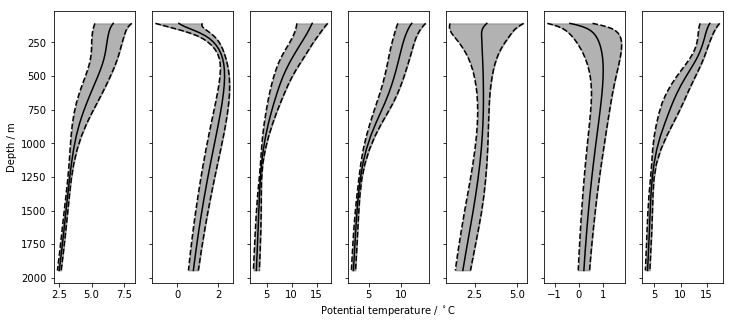

In [17]:
m_id = ids[1]
filename = 'example-profiles-1'
#inds = flt.temp_sort(None, avg_profiles[ids[0]], True)
#inds = flt.match_profiles([avg_profiles[ids[0]][i] for i in inds], avg_profiles[ids[1]])
inds = None
figure, axes = plt.subplots(1, n_classes, sharey=True)
for (i, ax) in enumerate(axes):
  if i != 0:
    pass
  else:
    ax.set_ylabel('Depth / m')
    ax.invert_yaxis()
    
  if inds is None:
    inds = np.arange(0, n_classes)
  
  j=inds[i]
  ax.plot(avg_profiles[m_id][j]['mean'], lev_v, c='black')
  x2 = avg_profiles[m_id][j]['mean'] + avg_profiles[m_id][j]['std']
  x1 = avg_profiles[m_id][j]['mean'] - avg_profiles[m_id][j]['std']
  ax.plot(x2, lev_v, c='black', ls='--')
  ax.plot(x1, lev_v, c='black', ls='--')
  ax.fill_betweenx(lev_v, x1, x2, color='black', alpha=0.3)
  
  

figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Potential temperature / ${}^\circ$C')
#ax = plt.subplot(111)
#ax.set_xlabel('Potential temperature')
figure.set_size_inches(12, 5)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300, bbox_inches='tight')

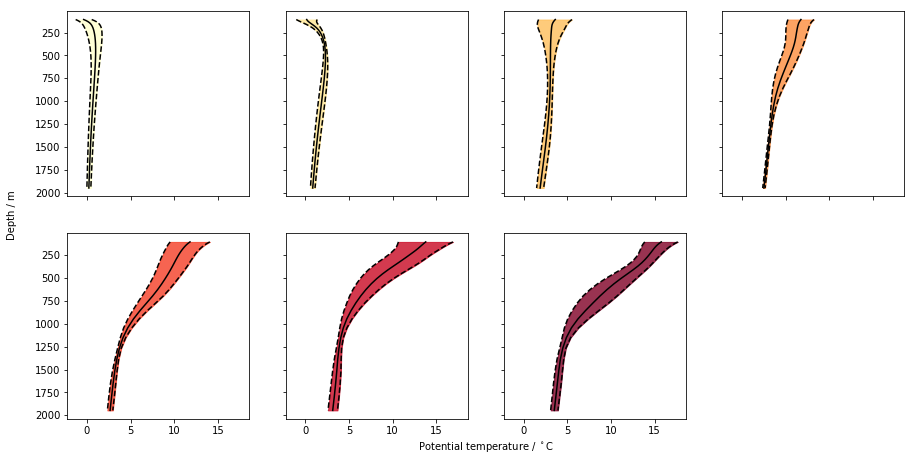

In [66]:
cmap = matplotlib.cm.get_cmap('YlOrRd')

filename = 'mean-profiles'
figure, axes = plt.subplots(2, 4, sharey=True, sharex=True)
axes = axes.flatten()
xs = np.mean(means, axis=0)
xs_p = np.mean(means, axis=0) + np.mean(stds, axis=0)
xs_m = 2*xs - xs_p
for (i, ax) in enumerate(axes):
  if i >= n_classes:
    figure.delaxes(ax)
    break
  rgba = list(cmap(i / (n_classes - 1)))
  rgba[-1] = 0.8
  
  ax.plot(xs[i, :], lev_v, c='black')
  ax.plot(xs_p[i, :], lev_v, c='black', ls='--')
  ax.plot(xs_m[i, :], lev_v, c='black', ls='--')
  ax.fill_betweenx(lev_v, xs_m[i, :], xs_p[i, :], color=rgba)
  ax.invert_yaxis()
  
figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Potential temperature / ${}^\circ$C')
plt.ylabel('Depth / m\n\n')
#ax = plt.subplot(111)
#ax.set_xlabel('Potential temperature')
figure.set_size_inches(15, 7.5)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300, bbox_inches='tight')